# <a id='toc1_'></a>[Проект: Прогнозирование оттока клиентов банка с помощью машинного обучения](#toc0_)

## <a id='toc1_1_'></a>[Описание проекта](#toc0_)
Банк сталкивается с проблемой оттока клиентов, что негативно влияет на прибыль. Для минимизации потерь необходимо заранее выявлять клиентов, склонных к уходу, и предлагать им персональные условия. В рамках проекта проведён анализ данных, предсказание оттока с помощью ML-моделей и подготовка решения для внедрения в коммерческое использование.

## <a id='toc1_2_'></a>[Цель исследования](#toc0_)
Разработать модель, которая с высокой точностью прогнозирует вероятность ухода клиента, и подготовить её к коммерческой эксплуатации.

---

## <a id='toc1_3_'></a>[Вопросы](#toc0_)
1. `Предобработка данных:`
   - Как кодировать категориальные признаки?
   - Нужно ли масштабировать числовые признаки?

2. `Выбор модели:`
   - Какая модель (логистическая регрессия, случайный лес, XGBoost и т.д.) показывает лучшие метрики на тестовых данных?

3. `Оптимизация:`
   - Как можно улучшить прогноз моделей и какую метрику для этого стоит использовать?
   - Как использовать кросс-валидацию для предотвращения переобучения модели?

4. `Оценка:`
   - Какая из оптимизированных моделей лучше работает на тестовой выборке?

5. `Деплоймент:`
   - Какие обязательные и рекомендательные шаги необходимо выполнить для подготовки модели к коммерческому использованию?

---
## <a id='toc1_4_'></a>[Поля данных](#toc0_)

`customer_id` - уникальный идентификатор клиента в системе банка.

`credit_score` - кредитный рейтинг, отражающий кредитоспособность клиента.

`country` - страна проживания клиента.

`gender` - пол клиента.

`age` - возраст клиента.

`tenure` - количество лет, в течение которых клиент пользуется услугами банка.

`balance`  - сумма денег на счете клиента.

`products_number` - количество банковских продуктов, которыми пользуется клиент.

`credit_card` - Наличие кредитной карты. Бинарный признак: 1 — у клиента есть кредитная карта, 0 — нет.

`active_member` - активный клиент. Бинарный признак: 1 — клиент активно пользуется услугами банка, 0 — неактивен.

`estimated_salary` - оценка годового дохода клиента.

`churn` - Целевая переменная: 1 — клиент ушел из банка, 0 — клиент остался.

Источник данных: https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset?resource=download

**Содержание:**<a id='toc0_'></a>    
- [Проект: Прогнозирование оттока клиентов банка с помощью машинного обучения](#toc1_)    
  - [Описание проекта](#toc1_1_)
  - [Цель исследования](#toc1_2_)
  - [Вопросы](#toc1_3_)    
  - [Поля данных](#toc1_4_)    
- [Обзор данных](#toc2_)
- [Предобработка данных](#toc3_)    
- [Сравнение 12 моделей для прогнозов](#toc4_)    
- [Тонкая настройка моделей](#toc5_)    
  - [Модель CatBoost](#toc5_1_)    
  - [Модель Gradient Boosting](#toc5_2_)    
- [Шаги подготовки модели для коммерческого использования](#toc6_)
- [Вывод:](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

Импорт библиотек:

In [13]:
import pandas as pd
import numpy as np

# Сети. Дополнительно
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Сети. Модели
from catboost import CatBoostClassifier
from catboost import Pool
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              AdaBoostClassifier, ExtraTreesClassifier)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Сети. Оптимизация
import optuna
from sklearn.model_selection import StratifiedKFold
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

# Построение графиков
import plotly.io as pio
import optuna.visualization as vis
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_intermediate_values

# Рендерер по умолчанию статический
pio.renderers.default = "png"

---
# <a id='toc2_'></a>[Обзор данных](#toc0_)


Чтение данных:

In [14]:
# чтение данных
df_ml = pd.read_csv('data\\bank_customer.csv', sep = ',')

# определение функции для диагностики df
def df_diagnostics(df1):
    # основные характеристики столбцов
    diag = pd.DataFrame({
        'dtypes': df1.dtypes,
        'count': df1.count(),
        'unique': df1.nunique(),
        'nan_count': df1.isnull().sum(),
        'nan_%': df1.isnull().sum() / df1.shape[0] * 100})

    metrics = {
        'mean': lambda s: s.mean(),
        'median': lambda s: s.median(),
        'min': lambda s: s.min(),
        'max': lambda s: s.max()}

    # метрики только для числовых столбцов
    numeric_cols = df1.select_dtypes(include=[np.number]).columns
    for metric, func in metrics.items():
        diag[metric] = [func(df1[col]) if col in numeric_cols else np.nan
                        for col in df1.columns]

    # количество дублирующих строк в df
    duplicates_count = df1.duplicated().sum()
    print("Количество дублирующих строк:", duplicates_count)

    # df с градиентной подсветкой, форматированием и округлением чисел
    return (diag.style.background_gradient(cmap='Set3', low=0.1, high=0.01)
            .format("{:.2f}", subset=diag.select_dtypes(include=[np.number]).columns))

In [15]:
df_ml.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Информация о таблице:

In [16]:
df_diagnostics(df_ml)

Количество дублирующих строк: 0


,dtypes,count,unique,nan_count,nan_%,mean,median,min,max
customer_id,int64,10000.00,10000.00,0.00,0.00,15690940.57,15690738.00,15565701.00,15815690.00
credit_score,int64,10000.00,460.00,0.00,0.00,650.53,652.00,350.00,850.00
country,object,10000.00,3.00,0.00,0.00,nan,nan,nan,nan
gender,object,10000.00,2.00,0.00,0.00,nan,nan,nan,nan
age,int64,10000.00,70.00,0.00,0.00,38.92,37.00,18.00,92.00
tenure,int64,10000.00,11.00,0.00,0.00,5.01,5.00,0.00,10.00
balance,float64,10000.00,6382.00,0.00,0.00,76485.89,97198.54,0.00,250898.09
products_number,int64,10000.00,4.00,0.00,0.00,1.53,1.00,1.00,4.00
credit_card,int64,10000.00,2.00,0.00,0.00,0.71,1.00,0.00,1.00
active_member,int64,10000.00,2.00,0.00,0.00,0.52,1.00,0.00,1.00


Анализ информации о таблице показал, что:
- клиенты банка по полю `customer_id` все уникальные
- имена полей корректные
- типы данных в полях корректны
- в полях пропусков нет

---
# <a id='toc3_'></a>[Предобработка данных](#toc0_)


Определим функцию для наложения на df тепловой карты:

In [17]:
def highlight_heatmap(data, col_heatmap=None, cmap='RdYlGn', decimal_places=2):
    """Наложение тепловой карты с округлением значений на указанные столбцы.

    :param data: Исходные данные (DataFrame или Series)
    :param col_heatmap: Список столбцов для тепловой карты
    :param cmap: Цветовая палитра
    :param decimal_places: Количество знаков после запятой
    :return: Стилизованный DataFrame
    """
    if isinstance(data, pd.Series):
        data = data.to_frame()

    styled_df = data.style

    if col_heatmap:
        # Форматирование чисел перед применением стилей
        format_str = f"{{:.{decimal_places}f}}"
        styled_df = styled_df.format(format_str, subset=col_heatmap)

        # Применение тепловой карты
        for col in col_heatmap:
            styled_df = styled_df.background_gradient(
                subset=[col], cmap=cmap)

    return styled_df

Приступим к предобработке данных для построения модели прогнозирования:

In [18]:
# Удалим поле `customer_id`, так как оно не несёт полезной информации
df_ml.drop(columns=['customer_id'], inplace=True)

# Преобразуем с помощью `One-Hot Encoding` категориальные признаки в полях `country` и `gender`:
# После этого в df появятся новые столбцы: `country_Germany`, `country_Spain`, `gender_Male`
df_ml = pd.get_dummies(df_ml, columns=['country', 'gender'], drop_first=True)

# Масштабируем числовые признаки в полях, значения которых могут достигать больших размеров
scaler = StandardScaler()
df_ml[['credit_score', 'age', 'balance', 'estimated_salary']] = scaler.fit_transform(
        df_ml[['credit_score', 'age', 'balance', 'estimated_salary']])

# Проверим баланс классов целевой переменной
print('Баланс классов целевой переменной:')
df_ml['churn'].value_counts(normalize=True)

Баланс классов целевой переменной:


churn
0    0.7963
1    0.2037
Name: proportion, dtype: float64

Выведем таблицу данных после предобработки:

In [19]:
df_ml.head()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_Germany,country_Spain,gender_Male
0,-0.326221,0.293517,2,-1.225848,1,1,1,0.021886,1,False,False,False
1,-0.440036,0.198164,1,0.117350,1,0,1,0.216534,0,False,True,False
2,-1.536794,0.293517,8,1.333053,3,1,0,0.240687,1,False,False,False
3,0.501521,0.007457,1,-1.225848,2,0,0,-0.108918,0,False,False,False
4,2.063884,0.388871,2,0.785728,1,1,1,-0.365276,0,False,True,False


`Вывод:` в процессе подготовки данных мы выполнили:
- удалили поле "customer_id", так как оно не нужно для обучения.
- с помощью метода "get_dummies" преобразовали категориальные признаки в полях "country" и "gender".
- с помощью метода "StandardScaler" масштабировали числовые признаки в некоторых полях.
- проверили баланс целевой переменной и получили 80% класса 1 и 20% класса 2.

В итоге мы получили 11 полей признаков и поле целевой переменной `churn`.

---
# <a id='toc4_'></a>[Сравнение 12 моделей для прогнозов](#toc0_)

Разделим данные на обучающие и тренировочные:

In [20]:
# Разделим данные на признаки (X) и целевую переменную (y):
X = df_ml.drop(columns=['churn'])
y = df_ml['churn']

# Разделим данные на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Далее построим связку для обучения нескольких моделей пока без подбора гиперпараметров и вывод результатов прогноза для каждой модели:

In [21]:
def train_and_predict(X_train, X_test, y_train, y_test, network):

    random_state = 42

    # Выбор модели
    if network == "Logistic Regression":
        model2 = LogisticRegression(max_iter=1000)
    elif network == "Random Forest":
        model2 = RandomForestClassifier(n_estimators=100, random_state=random_state)
    elif network == "Gradient Boosting":
        model2 = GradientBoostingClassifier(n_estimators=100, random_state=random_state)
    elif network == "SVM (RBF Kernel)":
        model2 = SVC(kernel='rbf', probability=True, random_state=random_state)
    elif network == "K-Nearest Neighbors (KNN)":
        model2 = KNeighborsClassifier(n_neighbors=5)
    elif network == "XGBoost":
        model2 = XGBClassifier(random_state=random_state)
    elif network == "CatBoost":
        model2 = CatBoostClassifier(random_state=random_state, verbose=0,
                                    allow_writing_files=False)  # verbose=0 для отключения логов
    elif network == "AdaBoost":
        model2 = AdaBoostClassifier(random_state=random_state)
    elif network == "Extra Trees":
        model2 = ExtraTreesClassifier(random_state=random_state)
    elif network == "Multi-layer Perceptron (MLP)":
        model2 = MLPClassifier(random_state=random_state, max_iter=1000)
    elif network == "Gaussian Naive Bayes":
        model2 = GaussianNB()
    elif network == "Decision Tree":
        model2 = DecisionTreeClassifier(random_state=random_state)
    else:
        raise ValueError("Неверный тип модели. Допустимые значения: 1-15.")

    # Обучаем модель
    model2.fit(X_train, y_train)

    # Предсказание на валидационной выборке
    y_val_pred = model2.predict(X_test)
    y_val_probs = model2.predict_proba(X_test)[:, 1]

    # Вычисляем метрики
    accuracy = round(accuracy_score(y_test, y_val_pred), 3)
    f1score = round(f1_score(y_test, y_val_pred), 3)
    auc = round(roc_auc_score(y_test, y_val_probs), 3)

    return accuracy, f1score, auc

Запустим для каждой модели обучение и прогноз. Выведем таблицу метрик моделей:

In [22]:
# Модели машинного обучения
neural_network = {1: "Logistic Regression", 2: "Random Forest", 3: "Gradient Boosting", 4: "SVM (RBF Kernel)",
                  5: "K-Nearest Neighbors (KNN)", 6: "XGBoost", 7: "CatBoost", 8: "AdaBoost", 9: "Extra Trees",
                  10: "Multi-layer Perceptron (MLP)", 11: "Gaussian Naive Bayes", 12: "Decision Tree"}

# перебор сетей по очереди
network_set = [neural_network[key] for key in range(1, 13)]

# Создаем пустой DataFrame для аккумуляции данных статистики
df_enumeration = pd.DataFrame(index=network_set, columns=['Accuracy', 'F1_score', 'AUC'])

for network_name in network_set:
    # вызов функции с выполнением прогноза
    accuracy, f1score, auc = train_and_predict(X_train, X_test, y_train, y_test, network=network_name)

    # сохраняем в таблицу замер качества прогноза
    df_enumeration.loc[network_name, ['Accuracy', 'F1_score', 'AUC']] = accuracy, f1score, auc

# Для наглядности накладываем на каждое поле df отдельную тепловую карту
styled_df = highlight_heatmap(df_enumeration, ['Accuracy', 'F1_score', 'AUC'],
                              decimal_places=3)

styled_df

,Accuracy,F1_score,AUC
Logistic Regression,0.808,0.284,0.775
Random Forest,0.865,0.583,0.852
Gradient Boosting,0.870,0.605,0.871
SVM (RBF Kernel),0.822,0.243,0.839
K-Nearest Neighbors (KNN),0.832,0.465,0.760
XGBoost,0.849,0.565,0.833
CatBoost,0.870,0.606,0.862
AdaBoost,0.860,0.568,0.848
Extra Trees,0.859,0.562,0.846
Multi-layer Perceptron (MLP),0.864,0.596,0.860


`Вывод:`

`Лучшие модели:`
- CatBoost (`Accuracy=0.87`, `F1=0.606`, `AUC=0.862`).
- Gradient Boosting (`Accuracy=0.87`, `F1=0.605`, `AUC=0.871`).

`Почему они лучшие?`
- Высокие значения всех трёх метрик, что указывает на сбалансированность модели.
- F1-score > 0.6 — это сильный показатель для задач с дисбалансом классов (предполагается, что данные несбалансированы, так как Accuracy высокий, а F1 низкий у других моделей).
- AUC > 0.85 — модель хорошо разделяет классы.

---
# <a id='toc5_'></a>[Тонкая настройка моделей](#toc0_)

Для снижения потребления памяти выполним преобразование данных в массивы numpy с типами для признаков float32 и для целевой переменной int8:

In [23]:
# Преобразование всего DataFrame в float32
X_np = X_train.to_numpy(dtype=np.float32)

# Преобразование целевой переменной в int8
y_np = y_train.to_numpy(dtype=np.int8)

# Делим данные на фолды 1 раз до подбора
splits = list(StratifiedKFold(n_splits=5).split(X_np, y_np))

Выполним подбор гиперпараметров для двух отобранных моделей с помощью библиотеки Optuna. Параметры для подбора и пространства параметров определены с помощью официальной документации методов машинного обучения. На каждую модель по 2 исследования: первое в 100 испытаний для определения областей пространств параметров для дальнейшего сужения и второе в 1000 испытаний для тонкой настройки для максимизации метрики F1-score. Данная метрика выбрана потому, что она лучше отражает качество модели и её стабильность, чем Accuracy, которая на переобученной модели может показывать высокие значения метрики, а после этого на тестовых данных покажет низкие метрики.

## <a id='toc5_1_'></a>[Модель CatBoost](#toc0_)

In [24]:
# Стратифицированная кросс-валидация для CatBoost
def cross_validate_catb(trial, params, X_np, y_np, splits):
    f1_scores = []

    for fold_idx, (train_idx, val_idx) in enumerate(splits):
        X_tr, X_val = X_np[train_idx], X_np[val_idx]
        y_tr, y_val = y_np[train_idx], y_np[val_idx]

        model = CatBoostClassifier(**params)
        # оптимальный формат данных Pool для CatBoost
        train_pool = Pool(X_tr, y_tr)
        val_pool = Pool(X_val, y_val)

        model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=20, verbose=False)

        y_pred1 = model.predict(X_val).astype(np.int32)
        fold_f1 = f1_score(y_val, y_pred1, average='binary')
        f1_scores.append(fold_f1)

        # Отправляем промежуточный результат
        current_mean = np.mean(f1_scores)
        trial.report(current_mean, step=fold_idx)

        # Проверяем необходимость прерывания
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return np.mean(f1_scores)

# Главная функция испытаний для CatBoost
def objective_catb(trial):
    search_params = {  # Параметры для подбора
        'iterations': trial.suggest_int('iterations', 1000, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 2e-1, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 5),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 5.0, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-1, 0.4, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.5, 1.0),
        'border_count': trial.suggest_int('border_count', 150, 254),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 140, 180),
        'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['Balanced',]),
    }

    fixed_params = {  # Фиксированные параметры
        # параметр метрики
        'eval_metric': 'F1',
        # критерии для ранней остановки
        'od_type': 'Iter',
        'od_wait': 20,

        'bootstrap_type': 'Bayesian',
        'sampling_frequency': 'PerTreeLevel',
        'verbose': False}

    # Объединение параметров
    params = {**search_params, **fixed_params}

    # Вызов кросс-валидации с передачей trial
    return cross_validate_catb(trial, params, X_np, y_np, splits)

# отключение логирования в вывод
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Настройка исследования
study_catb = optuna.create_study(direction='maximize', load_if_exists=True,
                                 sampler=TPESampler(seed=42, n_startup_trials=20),
                                 # 3 фолдов перед проверкой и 5 trials для расчёта медианы
                                 pruner=MedianPruner(n_warmup_steps=3, n_min_trials=5),
                                 storage="sqlite:///optuna_studies/my_study.db",
                                 study_name="CatBoost_2")

# optuna-dashboard sqlite:///bank_customer_predict/optuna_studies/my_study.db

study_catb.optimize(objective_catb, n_trials=1000, show_progress_bar=True)

# Выводим результаты лучшего trial
print('Завершен подбор параметров для CatBoost\n\nЛучший trial:')
best_trial = study_catb.best_trial
print(f'  F1-score: {best_trial.value:.4f}')
print('  Параметры:')
for key, value in best_trial.params.items():
    print(f'    {key}: {value}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Завершен подбор параметров для CatBoost

Лучший trial:
  F1-score: 0.6276
  Параметры:
    iterations: 1698
    learning_rate: 0.2069699348425633
    depth: 4
    l2_leaf_reg: 6.470840434735456
    random_strength: 0.15809192967550417
    bagging_temperature: 0.572894491245495
    border_count: 252
    grow_policy: SymmetricTree
    min_data_in_leaf: 153
    auto_class_weights: Balanced


`1 исследование:`

`Результаты:` F1-score: 0.6187873626771246

`Параметры подобранные:` = iterations: 1629, learning_rate: 0.23594916342340075, depth: 6, l2_leaf_reg: 12.37221802451466, random_strength: 0.4351987298552858, bagging_temperature: 1.1467877895618392, border_count: 199, grow_policy: Depthwise, min_data_in_leaf: 164, auto_class_weights: Balanced

`Примечания:` 100 испытаний для определения более узких пространств параметров, в которых продолжить испытания. С помощью Optuna Dashboard определяем более узкие пространства параметров и запускаем второе исследование

`2 исследование:`

`Результаты:` F1-score: 0.6275886425078018

`Параметры подобранные:` = iterations: 1698, learning_rate: 0.2069699348425633, depth: 4, l2_leaf_reg: 6.470840434735456, random_strength: 0.15809192967550417, bagging_temperature: 0.572894491245495, border_count: 252, grow_policy: SymmetricTree, min_data_in_leaf: 153, auto_class_weights: Balanced

`Примечания:` 1000 испытаниями для более тонкой подборки параметров

Оценка метрик модели CatBoost с лучшими подобранными параметрами на тестовой выборке:

In [25]:
# Получаем лучшие параметры из исследования
best_params_catb = study_catb.best_trial.params

# Создаем и обучаем модель с лучшими параметрами
model_catb = CatBoostClassifier(
    allow_writing_files=False,
    # Передавать фиксированные аргументы, если они есть!
    **best_params_catb)
model_catb.fit(X_train, y_train, verbose=False)

# Делаем предсказания
y_pred_catb = model_catb.predict(X_test)

# Вычисляем метрики
metrics_catb = {'Accuracy': round(accuracy_score(y_test, y_pred_catb), 3),
                'F1_score': round(f1_score(y_test, y_pred_catb), 3),
                'AUC': round(roc_auc_score(y_test, y_pred_catb), 3)}

# Выводим результаты
print('Метрики модели CatBoost:', metrics_catb)

Метрики модели CatBoost: {'Accuracy': 0.82, 'F1_score': 0.577, 'AUC': 0.74}


`Вывод:` Модель на тестовых данных показала следующие метрики:

До оптимизации: Accuracy 0.87, F1_score 0.606 и AUC 0.862

После оптимизации: Accuracy 0.82, F1_score 0.577 и AUC 0.74

С учётом того, что подбор параметров производился с применением cтратифицированной кросс-валидации с целью минимизировать переобучение, мы видим на выходе хорошие метрики. Можно конечно и дальше производить подбор с возможным незначительным улучшением метрик, если это оправдано.

Покажем ряд графиков по результатам оптимизации гиперпараметров

График истории оптимизации:

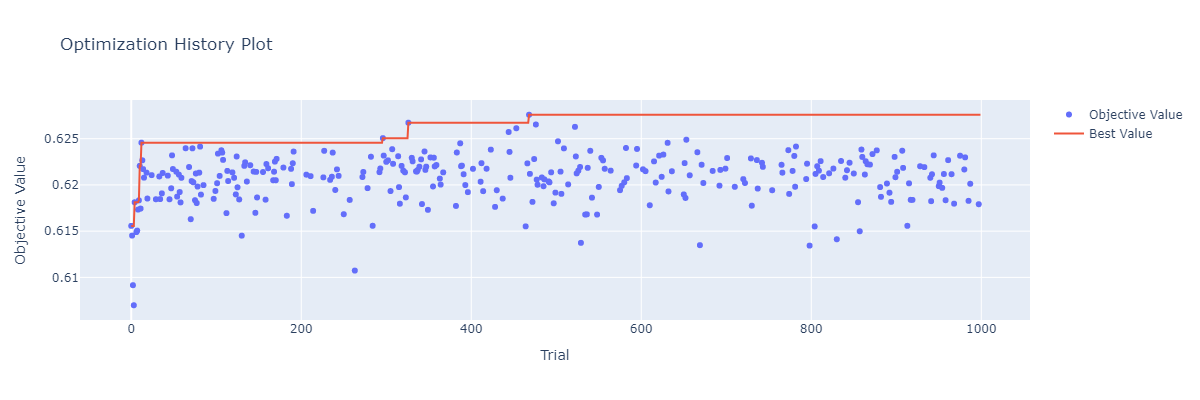

In [26]:
# Определим список параметров для визуализации
params_visual_catb = ['iterations','learning_rate','depth','l2_leaf_reg']

fig = plot_optimization_history(study_catb)
fig.update_layout(width=1200, height=400)
fig.show()

График промежуточных значений:

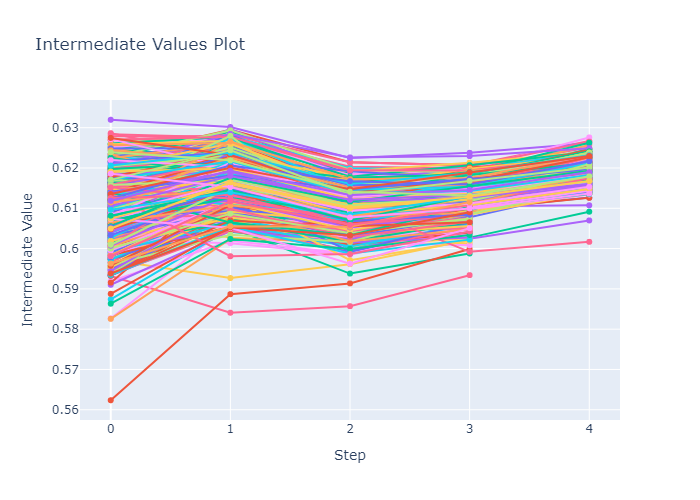

In [27]:
fig = plot_intermediate_values(study_catb)
fig.show()

График оптимальных диапазонов для параметров:

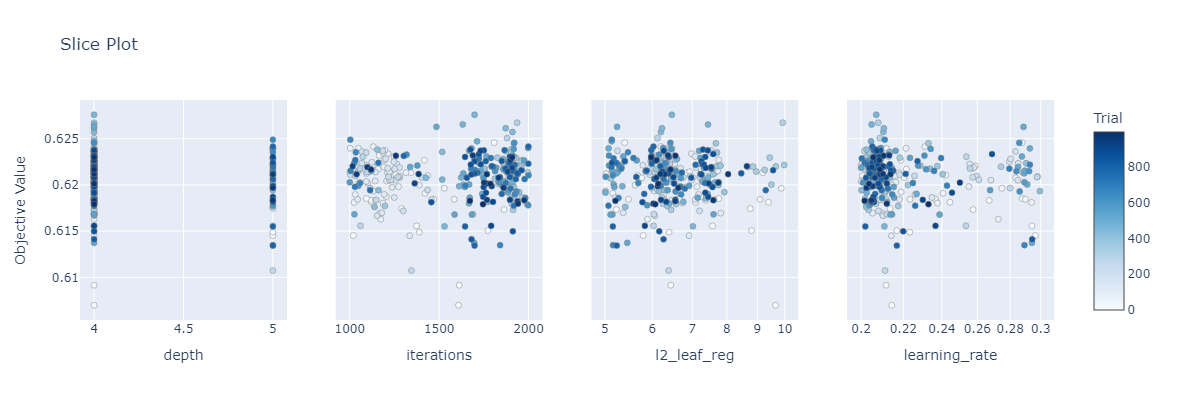

In [28]:
fig = vis.plot_slice(study_catb, params=params_visual_catb)
fig.update_layout(width=1200, height=400)
fig.show()

График параллельных координат:

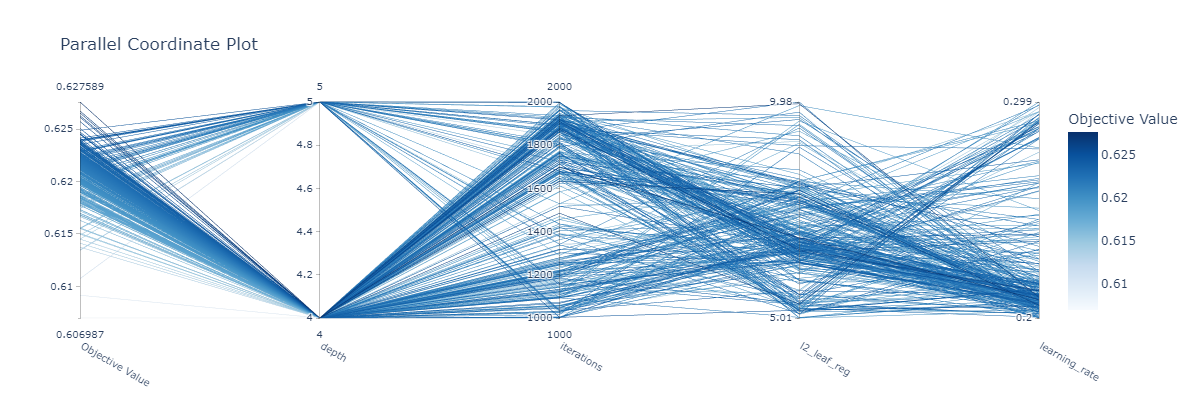

In [29]:
fig = vis.plot_parallel_coordinate(study_catb, params=params_visual_catb)
fig.update_layout(width=1200, height=400)
fig.show()

---
## <a id='toc5_2_'></a>[Модель Gradient Boosting](#toc0_)

In [31]:
# Стратифицированная кросс-валидация для Gradient Boosting
def cross_validate_gradb(trial, params, X_np, y_np, splits):
    f1_scores = []

    for fold_idx, (train_idx, val_idx) in enumerate(splits):
        X_tr, X_val = X_np[train_idx], X_np[val_idx]
        y_tr, y_val = y_np[train_idx], y_np[val_idx]

        model = GradientBoostingClassifier(**params)
        model.fit(X_tr, y_tr)

        y_pred1 = model.predict(X_val).astype(np.int32)
        fold_f1 = f1_score(y_val, y_pred1, average='binary')
        f1_scores.append(fold_f1)

        # Отправляем промежуточный результат
        current_mean = np.mean(f1_scores)
        trial.report(current_mean, step=fold_idx)

        # Проверяем необходимость прерывания
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return np.mean(f1_scores)

# Главная функция испытаний для Gradient Boosting
def objective_gradb(trial):
    search_params = {  # Параметры для подбора
        'learning_rate': trial.suggest_float('learning_rate', 8e-2, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 2000),
        'max_depth': trial.suggest_int('max_depth', 4, 6),
        'min_samples_split': trial.suggest_float('min_samples_split', 2e-3, 6e-3, log=True),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 4, 8),
        'max_features': trial.suggest_int('max_features', 5, 9),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 500, 1000),
        # Параметры ранней остановки для scikit-learn
        'validation_fraction': 0.1,
        'n_iter_no_change': 20,
        'tol': 1e-4
    }

    fixed_params = {  # Фиксированные параметры
        'verbose': False}

    # Объединение параметров
    params = {**search_params, **fixed_params}

    # Вызов кросс-валидации с передачей trial
    return cross_validate_gradb(trial, params, X_np, y_np, splits)

# отключение логирования в вывод
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Настройка исследования
study_gradb = optuna.create_study(direction='maximize', load_if_exists=True,
                                 sampler=TPESampler(seed=42, n_startup_trials=20),
                                 # 3 фолдов перед проверкой и 5 trials для расчёта медианы
                                 pruner=MedianPruner(n_warmup_steps=3, n_min_trials=5),
                                 storage="sqlite:///optuna_studies/my_study.db",
                                 study_name="GradBoost_2")

# optuna-dashboard sqlite:///bank_customer_predict/optuna_studies/my_study.db

study_gradb.optimize(objective_gradb, n_trials=1000, show_progress_bar=True)

# Выводим результаты лучшего trial
print('Завершен подбор параметров для Gradient Boosting\n\nЛучший trial:')
best_trial = study_gradb.best_trial
print(f'  F1-score: {best_trial.value:.4f}')
print('  Параметры:')
for key, value in best_trial.params.items():
    print(f'    {key}: {value}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Завершен подбор параметров для Gradient Boosting

Лучший trial:
  F1-score: 0.5982
  Параметры:
    learning_rate: 0.24924414687716523
    n_estimators: 1269
    max_depth: 5
    min_samples_split: 0.0032337352302126547
    min_samples_leaf: 5
    max_features: 9
    max_leaf_nodes: 790


`1 исследование:`

`Результаты:` F1-score: 0.5945486491556733

`Параметры подобранные:` = learning_rate: 0.15266841738756362, n_estimators: 562, subsample: 0.951690965506603, max_depth: 4, min_samples_split: 0.0043169589154911595, min_samples_leaf: 5, max_features: 9, max_leaf_nodes: 763

`Примечания:` 100 испытаний для определения более узких пространств параметров, в которых продолжить испытания. С помощью Optuna Dashboard определяем более узкие пространства параметров и запускаем второе исследование

`2 исследование:`

`Результаты:` F1-score: 5981607810939642

`Параметры подобранные:` = learning_rate: 0.24924414687716523, n_estimators: 1269, max_depth: 5, min_samples_split: 0.0032337352302126547, min_samples_leaf: 5, max_features: 9, max_leaf_nodes: 790

`Примечания:` 1000 испытаниями для более тонкой подборки параметров

Оценка метрик модели Gradient Boosting с лучшими подобранными параметрами на тестовой выборке:

In [32]:
# Получаем лучшие параметры из исследования
best_params_gradb = study_gradb.best_trial.params

# Создаем и обучаем модель с лучшими параметрами
model_gradb = GradientBoostingClassifier(**best_params_gradb)
model_gradb.fit(X_train, y_train)

# Делаем предсказания
y_pred_gradb = model_gradb.predict(X_test)

# Вычисляем метрики
metrics_gradb = {'Accuracy': round(accuracy_score(y_test, y_pred_gradb), 3),
                 'F1_score': round(f1_score(y_test, y_pred_gradb), 3),
                 'AUC': round(roc_auc_score(y_test, y_pred_gradb), 3)}

# Выводим результаты
print('Метрики модели Gradient Boosting:', metrics_gradb)

Метрики модели Gradient Boosting: {'Accuracy': 0.838, 'F1_score': 0.544, 'AUC': 0.703}


`Вывод:` Модель на тестовых данных показала следующие метрики:

До оптимизации: Accuracy 0.87, F1_score 0.605 и AUC 0.871

После оптимизации: Accuracy 0.838, F1_score 0.544 и AUC 0.703

С учётом того, что подбор параметров производился с применением cтратифицированной кросс-валидации с целью минимизировать переобучение, мы видим на выходе хорошие метрики. По субъективному мнению автора проекта модель CatBoost показала более лучшее качество, потому, что показатель F1_score у CatBoost 0.581, а у Gradient Boosting ниже 0.548. И в процессе выполнения оптимизации гиперпараметров модель CatBoost ведёт себя стабильнее - это видно на графиках промежуточных значений, которые представлены в проекте и их можно изучить.

Покажем ряд графиков по результатам оптимизации гиперпараметров

График истории оптимизации:

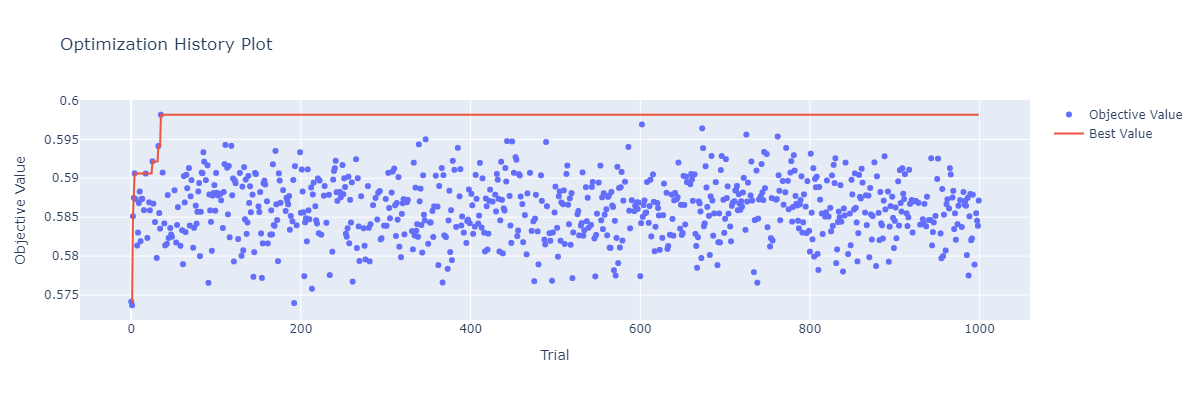

In [33]:
# Определим список параметров для визуализации
params_visual_gradb = ['learning_rate','n_estimators','max_depth','min_samples_split']

fig = plot_optimization_history(study_gradb)
fig.update_layout(width=1200, height=400)
fig.show()

График промежуточных значений:

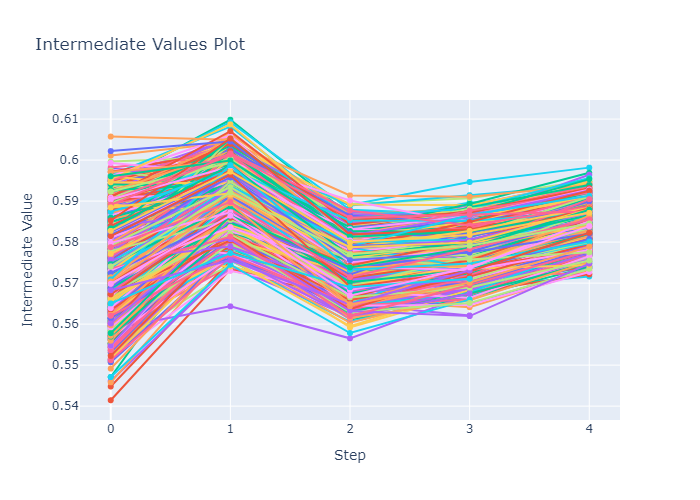

In [34]:
fig = plot_intermediate_values(study_gradb)
fig.show()

График оптимальных диапазонов для параметров:

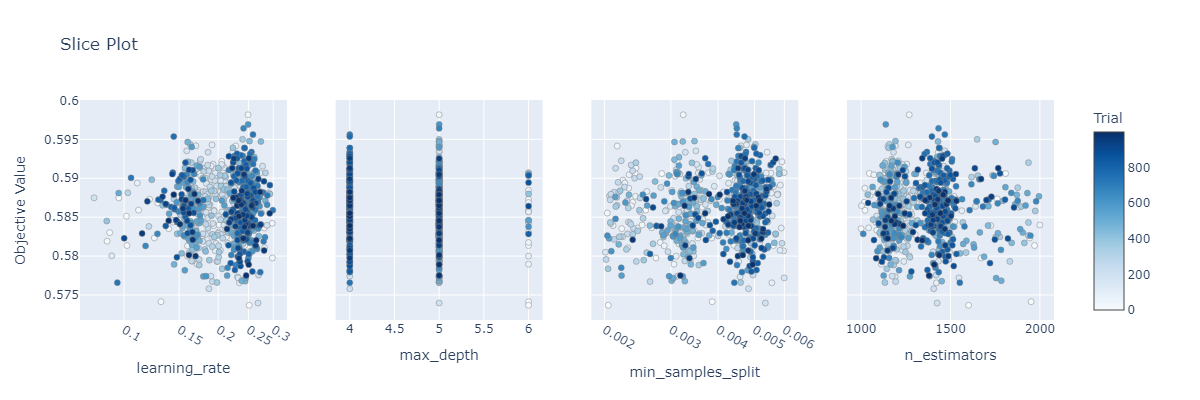

In [35]:
fig = vis.plot_slice(study_gradb, params=params_visual_gradb)
fig.update_layout(width=1200, height=400)
fig.show()

График параллельных координат:

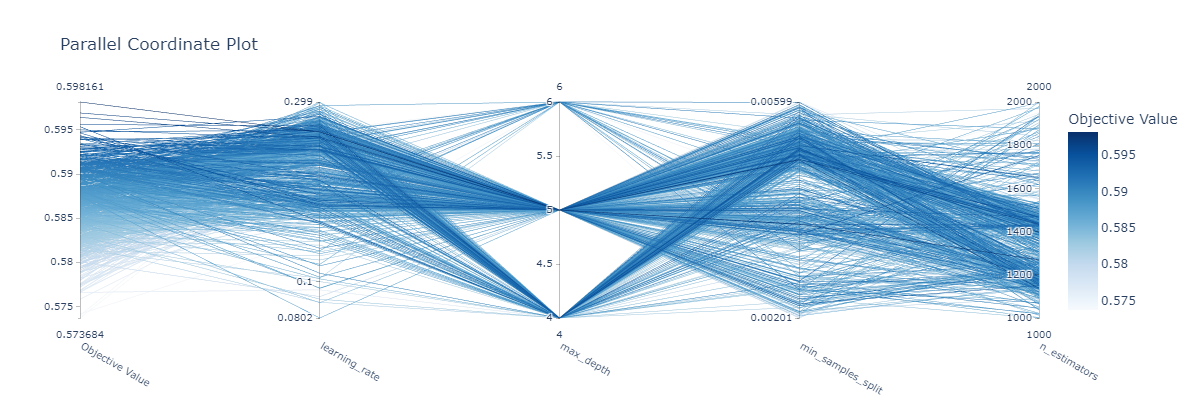

In [36]:
fig = vis.plot_parallel_coordinate(study_gradb, params=params_visual_gradb)
fig.update_layout(width=1200, height=400)
fig.show()

`Вывод:`
- Из 12 моделей для прогнозов мы определили 2 модели, которые дали наилучшие метрики без подбора гиперпараметров: 1) CatBoost (Accuracy 0.870, F1_score 0.606, AUC 0.862); 2) Gradient Boosting (Accuracy 0.870, F1_score 0.605, AUC 0.871).
- Далее мы для обеих моделей произвели оптимизацию параметров через Optuna. На каждую модель по 1 исследованию в 100 испытаний для сужения пространства параметров и по 1 исследованию в 1000 испытаний для тонкой настройки параметров. Важно сказать, что в обоих случаях с целью минимизации переобучения использовалась стратифицированная кросс-валидация. При подборе параметров цель исследований была максимизация метрики F1_score как среднего гармонического между Precision и Recall. Во время оптимизации параметров на обучающих данных у обеих моделей метрики выросли.
- После оптимизации параметров обе модели с лучшими комбинациями подобранных параметров были протестированы на тестовом наборе данных, который до этого модели не видели. Ожидаемо значения метрик получились немного ниже, чем метрики на обучающих данных. Но все равно метрики удовлетворительные и близких и двух моделей.

`Итоговые метрики:` моделей при проверке на тестовом наборе данных:
- модель CatBoost. Accuracy 0.82, F1_score 0.577 и AUC 0.74
- модель Gradient Boosting. Accuracy 0.838, F1_score 0.544 и AUC 0.703

---
# <a id='toc6_'></a>[Шаги подготовки модели для коммерческого использования](#toc0_)

Далее опишу шаги, обязательные и дополнительные рекомендуемые для выполнения, чтобы качественно подготовить модель к коммерческому использованию:

Обязательные шаги:
1. `Валидация модели` проверяем модель на отдельном тестовом наборе и убеждаемся, что метрики (accuracy, F1, ROC-AUC) соответствуют требованиям. Протестируем обработку аномалий (NaN, выбросы) в новых данных.
2. `Сериализация модели и пайплайна` сохраним модель вместе с пайплайном предобработки (например, joblib или pickle), чтобы гарантировать согласованность между обучением и продакшеном.
3. `Создание API для предсказаний` реализуем REST API (например, на FastAPI/Flask), который принимает входные данные и возвращает предсказания модели.
4. `Контейнеризация (Docker)` упакуем API, модель и зависимости в Docker-контейнер для изоляции среды и воспроизводимости.
5. `Базовый мониторинг` настроем логирование ошибок и метрик производительности API (например, задержки, статус ответов).

Рекомендуемые шаги:
1. `Настройка CI/CD пайплайна` автоматизируем тестирование, сборку контейнера и деплой при обновлении кода (GitHub Actions, GitLab CI).
2. `Мониторинг данных и модели` внедрим инструменты для отслеживания дрейфа данных (data drift) и деградации модели (Evidently AI, Prometheus).
3. `A/B-тестирование` запустим новую модель параллельно со старой для сравнения результатов (Canary-деплой).
4. `Автоматический ретранинг` настроим периодическое переобучение модели на новых данных (например, через Airflow или Prefect).
5. `Документация` создадим документацию по API (например, через Swagger/OpenAPI) и инструкции по развертыванию для команды.
6. `Управление версиями` используем инструменты вроде MLflow или DVC для контроля версий моделей, данных и экспериментов.

---
# <a id='toc7_'></a>[Вывод:](#toc0_)

`Предобработка данных` В процессе предобработки данных мы сделали следующее:
- удалили поле "customer_id", так как оно не нужно для обучения.
- с помощью метода "get_dummies" преобразовали категориальные признаки в полях "country" и "gender".
- с помощью метода "StandardScaler" масштабировали числовые признаки в некоторых полях.
- проверили баланс целевой переменной и получили 80% класса 1 и 20% класса 2.

В итоге мы получили 11 полей признаков и поле целевой переменной `churn`.

---
`Сравнение 12 моделей для прогноза` В процессе сравнения 12 моделей для прогнозов мы выявили две модели, прогноз которых показывает наилучшие метрики на тестовых данных:

`Лучшие модели:`
- CatBoost (`Accuracy=0.87`, `F1=0.606`, `AUC=0.862`).
- Gradient Boosting (`Accuracy=0.87`, `F1=0.605`, `AUC=0.871`).

`Почему они лучшие?`
- Высокие значения всех трёх метрик, что указывает на сбалансированность модели.
- F1-score > 0.6 — это сильный показатель для задач с дисбалансом классов (предполагается, что данные несбалансированы, так как Accuracy высокий, а F1 низкий у других моделей).
- AUC > 0.85 — модель хорошо разделяет классы.

---
Тонкая настройка моделей:

Выполнили подбор гиперпараметров для двух отобранных моделей с помощью библиотеки Optuna. Параметры для подбора и пространства параметров определены с помощью официальной документации методов машинного обучения. На каждую модель по 2 исследования: первое в 100 испытаний для определения областей пространств параметров для дальнейшего сужения и второе в 1000 испытаний для тонкой настройки для максимизации метрики F1-score. Данная метрика выбрана потому, что она лучше отражает качество модели и её стабильность, чем Accuracy, которая на переобученной модели может показывать высокие значения метрики, а после этого на тестовых данных покажет низкие метрики.

`CatBoost` Модель на тестовых данных показала следующие метрики:

До оптимизации: Accuracy 0.87, F1_score 0.606 и AUC 0.862

После оптимизации: Accuracy 0.82, F1_score 0.577 и AUC 0.74

С учётом того, что подбор параметров производился с применением cтратифицированной кросс-валидации с целью минимизировать переобучение, мы видим на выходе хорошие метрики. Можно конечно и дальше производить подбор с возможным незначительным улучшением метрик, если это оправдано.

`Gradient Boosting` Модель на тестовых данных показала следующие метрики:

До оптимизации: Accuracy 0.87, F1_score 0.605 и AUC 0.871

После оптимизации: Accuracy 0.838, F1_score 0.544 и AUC 0.703

С учётом того, что подбор параметров производился с применением cтратифицированной кросс-валидации с целью минимизировать переобучение, мы видим на выходе хорошие метрики. По субъективному мнению автора проекта модель CatBoost показала лучшее качество, потому, что показатель F1_score у CatBoost 0.577, а у Gradient Boosting ниже 0.544. И в процессе выполнения оптимизации гиперпараметров модель CatBoost ведёт себя стабильнее - это видно на графиках промежуточных значений, которые представлены в проекте и их можно изучить.

---
`Подготовка моделей для коммерческого использования` Далее опишу шаги, обязательные и дополнительные рекомендуемые для выполнения, чтобы качественно подготовить модель к коммерческому использованию:

Обязательные шаги:
1. `Валидация модели` проверяем модель на отдельном тестовом наборе и убеждаемся, что метрики (accuracy, F1, ROC-AUC) соответствуют требованиям. Протестируем обработку аномалий (NaN, выбросы) в новых данных.
2. `Сериализация модели и пайплайна` сохраним модель вместе с пайплайном предобработки (например, joblib или pickle), чтобы гарантировать согласованность между обучением и продакшеном.
3. `Создание API для предсказаний` реализуем REST API (например, на FastAPI/Flask), который принимает входные данные и возвращает предсказания модели.
4. `Контейнеризация (Docker)` упакуем API, модель и зависимости в Docker-контейнер для изоляции среды и воспроизводимости.
5. `Базовый мониторинг` настроем логирование ошибок и метрик производительности API (например, задержки, статус ответов).

Рекомендуемые шаги:
1. `Настройка CI/CD пайплайна` автоматизируем тестирование, сборку контейнера и деплой при обновлении кода (GitHub Actions, GitLab CI).
2. `Мониторинг данных и модели` внедрим инструменты для отслеживания дрейфа данных (data drift) и деградации модели (Evidently AI, Prometheus).
3. `A/B-тестирование` запустим новую модель параллельно со старой для сравнения результатов (Canary-деплой).
4. `Автоматический ретранинг` настроим периодическое переобучение модели на новых данных (например, через Airflow или Prefect).
5. `Документация` создадим документацию по API (например, через Swagger/OpenAPI) и инструкции по развертыванию для команды.
6. `Управление версиями` используем инструменты вроде MLflow или DVC для контроля версий моделей, данных и экспериментов.